In [1]:
import pandas as pd
import numpy as np

## Treemap images loading (X)

Images are cropped on their borders because of white edges. Then, they are resized in order to not take more memory than necessary.

In [2]:
%%time

# DL with Python - François Chollet (pp. 162-163)
from PIL import Image
from keras.preprocessing import image
import glob

path = '../data/COMMON_GENES_CHR_LOCUS_TREEMAPS/'
filelist = glob.glob(path + '*.png')

brca_images = dict()
non_brca_images = dict()
w, h = (image.load_img(filelist[1]).size)

basewidth = 100
wpercent = (basewidth/float(w))
hsize = int((float(h)*float(wpercent)))

i = 0 
for filename in filelist:
    sample = filename.split(" ")[1]
    if(True):
        if('NON' in sample):
            non_brca_images[sample.split("_")[0].replace('.','-')] = image.load_img(filename).crop((11, 11, w-13, h-13)).resize((basewidth,hsize), Image.ANTIALIAS)
        else:
            brca_images[sample.split("_")[0].replace('.','-')] = image.load_img(filename).crop((11, 11, w-13, h-13)).resize((basewidth,hsize), Image.ANTIALIAS)

Using TensorFlow backend.


CPU times: user 26.7 s, sys: 329 ms, total: 27 s
Wall time: 27 s


In [3]:
print('There are {} brca images and {} non-brca images'.format(len(brca_images), len(non_brca_images)))

There are 1212 brca images and 9323 non-brca images


## Visualizing some images

/home/mcabello/almacen/miniconda3/envs/maria_env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


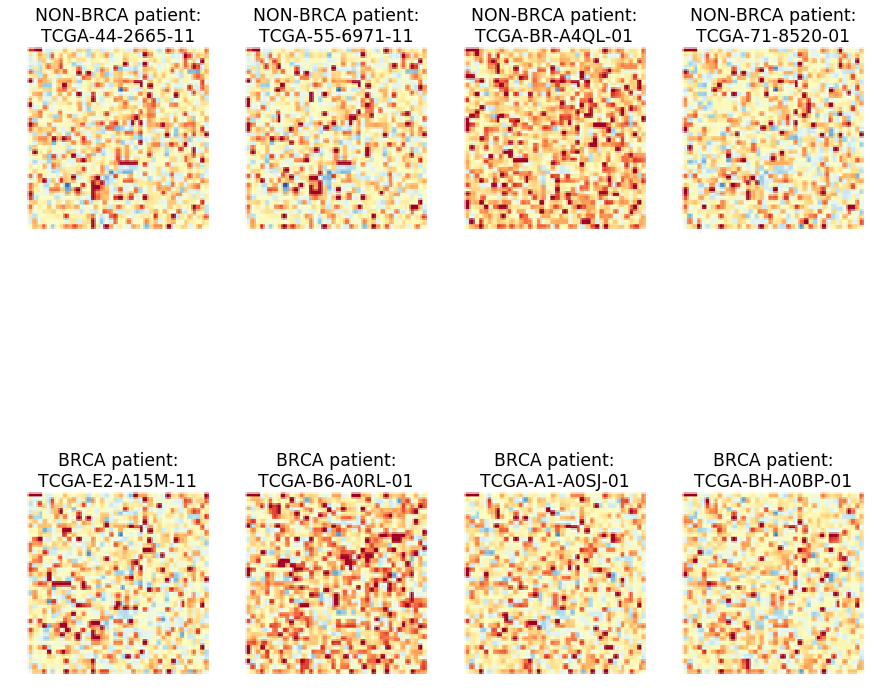

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.subplots(4,4,figsize=(15,15))
# plot
for i in range(0,8):
    key_img = list(non_brca_images.keys())[np.random.randint(len(non_brca_images),size= 1)[0]]
    image = non_brca_images[key_img]
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.title('NON-BRCA patient:\n' + key_img, fontsize='xx-large')
    plt.imshow(image)

for i in range(4,8):
    key_img = list(brca_images.keys())[np.random.randint(len(brca_images),size= 1)[0]]
    image = brca_images[key_img]
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.title('BRCA patient:\n' + key_img, fontsize='xx-large')
    plt.imshow(image)
    


## Survival data loading (Y)

In [4]:
brca_clinical = pd.read_hdf('../data/TCGA_data.h5', key='brca_clinical')
non_brca_clinical = pd.read_hdf('../data/TCGA_data.h5', key='non_brca_clinical')

In [5]:
# Deleting samples with 'NaN's in OS-columns 

## non_brca
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical['OS'] = non_brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].astype(float)
non_brca_clinical['OS'] = non_brca_clinical['OS'].astype(float)

## brca
brca_clinical['OS.time'] = brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical['OS'] = brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
brca_clinical['OS.time'] = brca_clinical['OS.time'].astype(float)
brca_clinical['OS'] = brca_clinical['OS'].astype(float)

In [6]:
print('There are {} brca clinical info and {} non-brca clinical info'.format(len(brca_clinical), len(non_brca_clinical)))

There are 1196 brca clinical info and 9224 non-brca clinical info


## Creating X and Y numpy-arrays

Note that there are differences between patients with survival info and with images; only patients in both datasets are mantained

In [7]:
common_pat_brca = set(brca_images.keys()).intersection(brca_clinical.index)

In [8]:
len(common_pat_brca)

1196

#### Deleting images and OS data from not common patients

In [9]:
# Mantaining brca patients with both X and Y available data
brca_clinical = brca_clinical.loc[common_pat_brca]

for k in set(list(brca_images.keys())).difference(common_pat_brca):
    del brca_images[k]

In [10]:
len(brca_images)

1196

In [11]:
len(brca_clinical)

1196

In [12]:
common_pat_non_brca = set(non_brca_images.keys()).intersection(non_brca_clinical.index)

In [13]:
len(common_pat_non_brca)

9224

In [14]:
# Mantaining brca patients with both X and Y available data
non_brca_clinical = non_brca_clinical.loc[common_pat_non_brca]

for k in set(list(non_brca_images.keys())).difference(common_pat_non_brca):
    del non_brca_images[k]

In [15]:
len(non_brca_images)

9224

In [16]:
len(non_brca_clinical)

9224

#### From OS to Survival

In [17]:
# Create 39 equally spaced intervals for follow-up time, from 0 to 5 years:
breaks = np.arange(0.,365.*5,365./8)
n_intervals = len(breaks)-1
timegap = breaks[1:] - breaks[:-1]

In [18]:
import nnet_survival
non_brca_y = nnet_survival.make_surv_array(non_brca_clinical['OS.time'],
                             non_brca_clinical['OS'],
                             breaks)
brca_y = nnet_survival.make_surv_array(brca_clinical['OS.time'],
                             brca_clinical['OS'],
                             breaks)

In [19]:
non_brca_clinical['OS.time'][12]

2203.0

In [20]:
non_brca_clinical['OS'][12]

0.0

In [21]:
sum(non_brca_y[12])

39.0

In [22]:
non_brca_y[12]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
breaks

array([   0.   ,   45.625,   91.25 ,  136.875,  182.5  ,  228.125,
        273.75 ,  319.375,  365.   ,  410.625,  456.25 ,  501.875,
        547.5  ,  593.125,  638.75 ,  684.375,  730.   ,  775.625,
        821.25 ,  866.875,  912.5  ,  958.125, 1003.75 , 1049.375,
       1095.   , 1140.625, 1186.25 , 1231.875, 1277.5  , 1323.125,
       1368.75 , 1414.375, 1460.   , 1505.625, 1551.25 , 1596.875,
       1642.5  , 1688.125, 1733.75 , 1779.375])

In [24]:
(912.5 + 958.125)/2

935.3125

#### From PIL.Images to Numpy

In [25]:
%%time

import numpy as np
from keras.preprocessing import image

samples = list(non_brca_clinical.index)

X_non_brca = np.empty((len(samples), 100, 100, 3))

for i in range(0, len(samples)):
    
    X_non_brca[i] = image.img_to_array(non_brca_images[samples[i]])

CPU times: user 466 ms, sys: 348 ms, total: 814 ms
Wall time: 813 ms


In [26]:
%%time

import numpy as np
from keras.preprocessing import image

samples = list(brca_clinical.index)

X_brca = np.empty((len(samples), 100, 100, 3))

for i in range(0, len(samples)):
    X_brca[i] = image.img_to_array(brca_images[samples[i]])

CPU times: user 55.7 ms, sys: 52 ms, total: 108 ms
Wall time: 107 ms


In [27]:
print("BRCA data shapes: \n X: {} \t Y: {}".format(X_brca.shape, brca_y.shape))

BRCA data shapes: 
 X: (1196, 100, 100, 3) 	 Y: (1196, 78)


In [28]:
print("Non-BRCA data shapes: \n X: {} \t Y: {}".format(X_non_brca.shape, non_brca_y.shape))

Non-BRCA data shapes: 
 X: (9224, 100, 100, 3) 	 Y: (9224, 78)


In [29]:
# to save memory
del non_brca_images
del brca_images

# TRAINING MODELS

In [30]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Activation, Dropout, Flatten
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import warnings
from keras.regularizers import l1
from keras.optimizers import Adam
import tensorflow as tf

In [31]:
# Using C-index as evaluation metric (using a custom callback)

from lifelines.utils import concordance_index
from keras.callbacks import Callback

class CIndex(Callback):
    """
    Callback that computes the C-index metric both on training and test data after each epoch.
    
    Arguments:
        train_x: Numpy array containing the training dataset.
        train_time: Numpy array with survival time for training dataset.
        train_event: Numpy array with survival event for training dataset.
        val_x: Numpy array containing the test dataset.
        val_time: Numpy array with survival time for test dataset.
        val_event: Numpy array with survival event for test dataset.
        filepath: path to save the model.
        years: number of years to compute c-index
        patience: patience for early-stop training
    """
    
    def __init__(self, train_x, train_time, train_event, val_x, val_time, val_event, filepath, years=2, patience=5):
        super(Callback, self).__init__()
        self.X_tr = train_x
        self.time_tr = train_time
        self.event_tr = train_event
        self.X_val = val_x
        self.time_val = val_time
        self.event_val = val_event
        self.years = years
        self.patience = patience
        self.best = 0.0
        self.wait = 0  #counter for patience
        self.best_rounds = 1
        self.counter = 0
        self.filepath = filepath
        
    def on_train_begin(self, logs={}):
        self.c_index_dict = {'c-index': [], 'val_c-index': []}

    def on_epoch_end(self, epoch, logs={}):
        self.counter +=1

        y_tr=self.model.predict_proba(self.X_tr,verbose=0)
        yr_surv=np.cumprod(y_tr[:,0:np.nonzero(breaks>365*self.years)[0][0]], axis=1)[:,-1]
        c_index_tr = concordance_index(self.time_tr, yr_surv, self.event_tr)
        y_val=self.model.predict_proba(self.X_val,verbose=0)
        yr_surv_val=np.cumprod(y_val[:,0:np.nonzero(breaks>365*self.years)[0][0]], axis=1)[:,-1]
        c_index_val = concordance_index(self.time_val, yr_surv_val, self.event_val)

        #print('\tc-index: %s - val_c-index: %s' % (str(round(c_index_tr, 4)), str(round(c_index_val, 4))))
        
        if (c_index_val > self.best):
            self.c_index_dict['c-index'].append(c_index_tr)
            self.c_index_dict['val_c-index'].append(c_index_val)

            self.best = c_index_val
            self.best_rounds = self.counter
            self.wait = 0
            self.model.save_weights(self.filepath, overwrite=True)
        else:
            if self.wait >= self.patience: #no more patience, retrieve best model
                self.model.stop_training = True
                print('Best number of rounds: %d \nValidation C-Index: %f \n' % (self.best_rounds, self.best))
                self.model.load_weights(self.filepath)
            self.wait += 1

## NON-BRCA

In [32]:
%%time
# Split dataset into train and test
from sklearn.model_selection import train_test_split

X_non_brca_train, X_non_brca_test, y_non_brca_train, y_non_brca_test, train_index, test_index = train_test_split(X_non_brca, non_brca_y, np.arange(len(X_non_brca)), test_size=0.2, random_state=42)
X_non_brca_train, X_non_brca_val, y_non_brca_train, y_non_brca_val, train_index, val_index = train_test_split(X_non_brca_train, y_non_brca_train, train_index, test_size=0.2, random_state=44)

CPU times: user 500 ms, sys: 782 ms, total: 1.28 s
Wall time: 1.28 s


### Bayesian Optimization (non-brca)

In [ ]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
space = {
    'conv_choice': hp.choice('conv_num_layers', 
                            [{'layers': 'two',
                             'units_2conv2': hp.choice('units_2conv2', [16, 32, 64, 128]),
                              '2kernel2': hp.choice('2kernel2', [3,5]),
                              '2pool2': 2,
                             'dropout_2conv2': hp.choice('dropout_2conv2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3conv2': hp.choice('units_3conv2', [16, 32, 64, 128]),
                             '3kernel2': hp.choice('3kernel2', [3,5]),
                             '3pool2': 2,
                             'dropout_3conv2': hp.choice('dropout_3conv2', [0.25, 0.5, 0.75]),
                             'units_3conv3': hp.choice('units_3conv3', [16, 32, 64, 128]),
                             '3kernel3': hp.choice('kernel3', [3,5]),
                             '3pool3': 2,
                             'dropout_3conv3': hp.choice('dropout_3conv3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'dense_choice': hp.choice('dense_num_layers', 
                            [{'layers': 'two',
                             'units_2dense2': hp.choice('units_2dense2', [16, 32, 64, 128]),
                             'dropout_2dense2': hp.choice('dropout_2dense2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3dense2': hp.choice('units_3dense2', [16, 32, 64, 128]),
                             'dropout_3dense2': hp.choice('dropout_3dense2', [0.25, 0.5, 0.75]),
                             'units_3dense3': hp.choice('units_3dense3', [16, 32, 64, 128]),
                             'dropout_3dense3': hp.choice('dropout_3dense3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'units_conv1': hp.choice('units_conv1', [16, 32, 64, 128]),
    'kernel1': hp.choice('kernel1', [3,5]),
    'pool1': 2,
    'dropout_conv1': hp.choice('dropout_conv1', [0.25, 0.5, 0.75]),
    'units_dense1': hp.choice('units_dense1', [16, 32, 64, 128]),
    'dropout_dense1': hp.choice('dropout_dense1', [0.25, 0.5, 0.75]),
    'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
    'nb_epochs' : 100,
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'activation': 'relu'                                            
}

In [ ]:
def train_non_brca(params):
    print('Params testing: ', params)
    print('\n')

    # Prevent GPU memory allocation problems
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    K.set_session(tf.Session(config=config))

    ## CREATE MODEL
    model = Sequential()

    # Conv layer 1 ---
    model.add(Conv2D(filters=params['units_conv1'], 
                     kernel_size=(params['kernel1'], params['kernel1']),
                     input_shape = (X_non_brca_train.shape[1],
                                    X_non_brca_train.shape[2],
                                    X_non_brca_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['pool1'],params['pool1'])))
    model.add(Dropout(params['dropout_conv1']))

    if params['conv_choice']['layers'] == 'two':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_2conv2'], 
                     kernel_size=(params['conv_choice']['2kernel2'], params['conv_choice']['2kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['2pool2'], params['conv_choice']['2pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_2conv2']))
    elif params['conv_choice']['layers'] == 'three':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv2'], 
                     kernel_size=(params['conv_choice']['3kernel2'], params['conv_choice']['3kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool2'], params['conv_choice']['3pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv2']))
        # Conv layer 3 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv3'], 
                     kernel_size=(params['conv_choice']['3kernel3'], params['conv_choice']['3kernel3'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool3'], params['conv_choice']['3pool3'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv3']))

    # Flatten layer ---
    model.add(Flatten())
    
    # Dense layer 1 ---
    model.add(Dense(params['units_dense1']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout_dense1']))

    if params['dense_choice']['layers']== 'two':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_2dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_2dense2']))
    elif params['dense_choice']['layers']== 'three':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_3dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense2']))
        # Dense layer 3 ---
        model.add(Dense(params['dense_choice']['units_3dense3']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense3']))
        
    # Output layer ---
    model.add(Dense(n_intervals, activation='sigmoid'))

    optimizer = Adam(lr=params['lr'])

    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)
    
    #model.summary()
    
    batch = params['batch_size']
    n_epoch = params['nb_epochs']

    hist_c_index = CIndex(X_non_brca_train,
                    non_brca_clinical.iloc[train_index]['OS.time'],
                    non_brca_clinical.iloc[train_index]['OS'],
                    X_non_brca_val,
                    non_brca_clinical.iloc[val_index]['OS.time'],
                    non_brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/best_non-brca.h5')

    callbacks = [hist_c_index]    
    
    ## Fit model using training data
    start = timer()
    model.fit(X_non_brca_train, 
              y_non_brca_train, 
              batch_size=batch, 
              epochs=n_epoch, 
              validation_data = [X_non_brca_val, y_non_brca_val],
              callbacks=callbacks,
              verbose=0)
    run_time = timer() - start
    
    predictions = model.predict_proba(X_non_brca_test,verbose=0)
    twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
    score = concordance_index(non_brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, non_brca_clinical.iloc[test_index]['OS'])

    # Return loss
    return {'loss': score*(-1),
            'params': params,
            'train_time': run_time,
            'status': STATUS_OK, 
            'rounds':hist_c_index.best_rounds}

In [ ]:
from timeit import default_timer as timer
from multiprocessing import Pool
from hyperopt import STATUS_OK

def objective_non_brca(params):
    from sklearn.metrics import roc_auc_score
    
    from keras.models import Sequential
    from keras.layers import Input, Dense, Conv1D, MaxPool1D, Activation, Dropout, Flatten
    from keras import regularizers, optimizers
    from keras.layers.normalization import BatchNormalization
    from keras.callbacks import EarlyStopping

    from keras.regularizers import l1
    from keras.optimizers import Adam
   
    with Pool(1) as p:
            trial = p.apply(train_non_brca, args=(params, ))

    return trial

### Train non-brca model with all non-brca data

In [33]:
import pickle

with open("keras-models/common_hyper_opt_chromosome_non-brca.pkl", 'rb') as f:
    [trials_non_brca, best_non_brca] = pickle.load(f)

In [34]:
params = trials_non_brca.best_trial['result']['params']

In [35]:
# Prevent GPU memory allocation problems
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
K.set_session(tf.Session(config=config))

## CREATE MODEL
model = Sequential()

# Conv layer 1 ---
model.add(Conv2D(filters=params['units_conv1'], 
                 kernel_size=(params['kernel1'], params['kernel1']),
                 input_shape = (X_non_brca.shape[1],
                                X_non_brca.shape[2],
                                X_non_brca.shape[3])))
model.add(BatchNormalization())
model.add(Activation(params['activation']))
model.add(MaxPool2D(pool_size=(params['pool1'],params['pool1'])))
model.add(Dropout(params['dropout_conv1']))

if params['conv_choice']['layers'] == 'two':
    # Conv layer 2 ---
    model.add(Conv2D(filters=params['conv_choice']['units_2conv2'], 
                 kernel_size=(params['conv_choice']['2kernel2'], params['conv_choice']['2kernel2'])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['conv_choice']['2pool2'], params['conv_choice']['2pool2'])))
    model.add(Dropout(params['conv_choice']['dropout_2conv2']))
elif params['conv_choice']['layers'] == 'three':
    # Conv layer 2 ---
    model.add(Conv2D(filters=params['conv_choice']['units_3conv2'], 
                 kernel_size=(params['conv_choice']['3kernel2'], params['conv_choice']['3kernel2'])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool2'], params['conv_choice']['3pool2'])))
    model.add(Dropout(params['conv_choice']['dropout_3conv2']))
    # Conv layer 3 ---
    model.add(Conv2D(filters=params['conv_choice']['units_3conv3'], 
                 kernel_size=(params['conv_choice']['3kernel3'], params['conv_choice']['3kernel3'])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool3'], params['conv_choice']['3pool3'])))
    model.add(Dropout(params['conv_choice']['dropout_3conv3']))

# Flatten layer ---
model.add(Flatten())

# Dense layer 1 ---
model.add(Dense(params['units_dense1']))
model.add(BatchNormalization())
model.add(Activation(params['activation']))
model.add(Dropout(params['dropout_dense1']))

if params['dense_choice']['layers']== 'two':
    # Dense layer 2 ---
    model.add(Dense(params['dense_choice']['units_2dense2']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dense_choice']['dropout_2dense2']))
elif params['dense_choice']['layers']== 'three':
    # Dense layer 2 ---
    model.add(Dense(params['dense_choice']['units_3dense2']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dense_choice']['dropout_3dense2']))
    # Dense layer 3 ---
    model.add(Dense(params['dense_choice']['units_3dense3']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dense_choice']['dropout_3dense3']))

# Output layer ---
model.add(Dense(n_intervals, activation='sigmoid'))

optimizer = Adam(lr=params['lr'])

model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)

#model.summary()

batch = params['batch_size']
n_epoch = params['nb_epochs']

callbacks = [EarlyStopping(monitor='loss', min_delta=0.01, patience=5, verbose=2, mode="min")]

## Fit model using training data
#tart = timer()
model.fit(X_non_brca, 
          non_brca_y, 
          batch_size=batch, 
          epochs=10,
          callbacks=callbacks)
          #bose=0)
#un_time = timer() - start

Epoch 1/10
9224/9224 [==============================] - 15s 2ms/step - loss: 2.4549
Epoch 2/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.5933
Epoch 3/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.5425
Epoch 4/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.5047
Epoch 5/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.4786
Epoch 6/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.4733
Epoch 7/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.4609
Epoch 8/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.4635
Epoch 9/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.4531
Epoch 10/10
9224/9224 [==============================] - 11s 1ms/step - loss: 1.4497


In [36]:
predictions = model.predict_proba(X_non_brca_test,verbose=0)
twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
score = concordance_index(non_brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, non_brca_clinical.iloc[test_index]['OS'])

In [37]:
score

0.7464245683451034

In [54]:
len(predictions[100])

39

In [52]:
len(y_non_brca_test[100])

78

In [50]:
sum(y_non_brca_test[100]==0)

57

In [59]:
len(y_non_brca_test[100])

78

In [57]:
len(y_non_brca_test[:,0:n_intervals][100])

39

In [41]:
cens_uncens = 1. + y_non_brca_test[:,0:n_intervals] * (predictions-1.)

In [43]:
uncens = 1. - y_non_brca_test[:,n_intervals:2*n_intervals] * predictions 

In [48]:
sum(cens_uncens[100]==1)

18

## BRCA

In [32]:
%%time
# Split dataset into train and test
from sklearn.model_selection import train_test_split

X_brca_train, X_brca_test, y_brca_train, y_brca_test, train_index, test_index = train_test_split(X_brca, brca_y, np.arange(len(X_brca)), test_size=0.2, random_state=42)
X_brca_train, X_brca_val, y_brca_train, y_brca_val, train_index, val_index = train_test_split(X_brca_train, y_brca_train, train_index, test_size=0.2, random_state=44)

CPU times: user 107 ms, sys: 108 ms, total: 215 ms
Wall time: 213 ms


### Bayesian Optimization (brca)

In [34]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
space = {
    'conv_choice': hp.choice('conv_num_layers', 
                            [{'layers': 'two',
                             'units_2conv2': hp.choice('units_2conv2', [16, 32, 64, 128]),
                              '2kernel2': hp.choice('2kernel2', [3,5]),
                              '2pool2': 2,
                             'dropout_2conv2': hp.choice('dropout_2conv2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3conv2': hp.choice('units_3conv2', [16, 32, 64, 128]),
                             '3kernel2': hp.choice('3kernel2', [3,5]),
                             '3pool2': 2,
                             'dropout_3conv2': hp.choice('dropout_3conv2', [0.25, 0.5, 0.75]),
                             'units_3conv3': hp.choice('units_3conv3', [16, 32, 64, 128]),
                             '3kernel3': hp.choice('kernel3', [3,5]),
                             '3pool3': 2,
                             'dropout_3conv3': hp.choice('dropout_3conv3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'dense_choice': hp.choice('dense_num_layers', 
                            [{'layers': 'two',
                             'units_2dense2': hp.choice('units_2dense2', [16, 32, 64, 128]),
                             'dropout_2dense2': hp.choice('dropout_2dense2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3dense2': hp.choice('units_3dense2', [16, 32, 64, 128]),
                             'dropout_3dense2': hp.choice('dropout_3dense2', [0.25, 0.5, 0.75]),
                             'units_3dense3': hp.choice('units_3dense3', [16, 32, 64, 128]),
                             'dropout_3dense3': hp.choice('dropout_3dense3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'units_conv1': hp.choice('units_conv1', [16, 32, 64, 128]),
    'kernel1': hp.choice('kernel1', [3,5]),
    'pool1': 2,
    'dropout_conv1': hp.choice('dropout_conv1', [0.25, 0.5, 0.75]),
    'units_dense1': hp.choice('units_dense1', [16, 32, 64, 128]),
    'dropout_dense1': hp.choice('dropout_dense1', [0.25, 0.5, 0.75]),
    'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
    'nb_epochs' : 100,
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'activation': 'relu'                                            
}

In [ ]:
def train_brca(params):
    print('Params testing: ', params)
    print('\n')

    # Prevent GPU memory allocation problems
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    K.set_session(tf.Session(config=config))

    ## CREATE MODEL
    model = Sequential()

    # Conv layer 1 ---
    model.add(Conv2D(filters=params['units_conv1'], 
                     kernel_size=(params['kernel1'], params['kernel1']),
                     input_shape = (X_brca_train.shape[1],
                                    X_brca_train.shape[2],
                                    X_brca_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['pool1'],params['pool1'])))
    model.add(Dropout(params['dropout_conv1']))

    if params['conv_choice']['layers'] == 'two':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_2conv2'], 
                     kernel_size=(params['conv_choice']['2kernel2'], params['conv_choice']['2kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['2pool2'], params['conv_choice']['2pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_2conv2']))
    elif params['conv_choice']['layers'] == 'three':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv2'], 
                     kernel_size=(params['conv_choice']['3kernel2'], params['conv_choice']['3kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool2'], params['conv_choice']['3pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv2']))
        # Conv layer 3 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv3'], 
                     kernel_size=(params['conv_choice']['3kernel3'], params['conv_choice']['3kernel3'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool3'], params['conv_choice']['3pool3'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv3']))

    # Flatten layer ---
    model.add(Flatten())
    
    # Dense layer 1 ---
    model.add(Dense(params['units_dense1']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout_dense1']))

    if params['dense_choice']['layers']== 'two':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_2dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_2dense2']))
    elif params['dense_choice']['layers']== 'three':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_3dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense2']))
        # Dense layer 3 ---
        model.add(Dense(params['dense_choice']['units_3dense3']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense3']))
        
    # Output layer ---
    model.add(Dense(n_intervals, activation='sigmoid'))

    optimizer = Adam(lr=params['lr'])

    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)
    
    #model.summary()
    
    batch = params['batch_size']
    n_epoch = params['nb_epochs']

    hist_c_index = CIndex(X_brca_train,
                    brca_clinical.iloc[train_index]['OS.time'],
                    brca_clinical.iloc[train_index]['OS'],
                    X_brca_val,
                    brca_clinical.iloc[val_index]['OS.time'],
                    brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/common_best_brca.h5')

    callbacks = [hist_c_index]    
    
    ## Fit model using training data
    start = timer()
    model.fit(X_brca_train, 
              y_brca_train, 
              batch_size=batch, 
              epochs=n_epoch, 
              validation_data = [X_brca_val, y_brca_val],
              callbacks=callbacks,
              verbose=0)
    run_time = timer() - start
    
    predictions = model.predict_proba(X_brca_test,verbose=0)
    twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
    score = concordance_index(brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, brca_clinical.iloc[test_index]['OS'])

    # Return loss
    return {'loss': score*(-1),
            'params': params,
            'train_time': run_time,
            'status': STATUS_OK, 
            'rounds':hist_c_index.best_rounds}

In [ ]:
from timeit import default_timer as timer
from multiprocessing import Pool
from hyperopt import STATUS_OK

def objective_brca(params):
    from sklearn.metrics import roc_auc_score
    
    from keras.models import Sequential
    from keras.layers import Input, Dense, Conv1D, MaxPool1D, Activation, Dropout, Flatten
    from keras import regularizers, optimizers
    from keras.layers.normalization import BatchNormalization
    from keras.callbacks import EarlyStopping

    from keras.regularizers import l1
    from keras.optimizers import Adam
   
    with Pool(1) as p:
            trial = p.apply(train_brca, args=(params, ))

    return trial

In [ ]:
import pickle

with open("keras-models/common_hyper_opt_chromosome_brca.pkl", 'rb') as f:
    [trials_brca, best_brca] = pickle.load(f)

In [ ]:
trials_brca.best_trial

## BRCA (fine tuning) 

#### Fine-tuning with Bayesian Optimization

Define the dictionary of hyper-parameter values to be tested:

In [35]:
space_fine_tuning = {
    'choice': hp.choice('num_layers', 
                            [{'layers': 'one'},
                            {'layers': 'two',
                             'units_2dense1': hp.choice('units_2dense1', [16, 32, 64, 128, 256]),
                             'dropout_2dense1': hp.choice('dropout_2dense1', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3dense1': hp.choice('units_3dense1', [16, 32, 64, 128, 256]),
                             'dropout_3dense1': hp.choice('dropout_3dense1', [0.25, 0.5, 0.75]),
                             'units_3dense2': hp.choice('units_3dense2', [16, 32, 64, 128, 256]),
                             'dropout_3dense2': hp.choice('dropout_3dense2', [0.25, 0.5, 0.75])
                            }]
                            ),
    'units_output': n_intervals,
    'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
    'nb_epochs' : 100,
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'activation_hidden': 'relu',
    'activation_output': 'sigmoid'
}

In [36]:
import nnet_survival

In [37]:
def train_fine_tuning(params):
    print('Params testing: ', params)
    print('\n')

    # Prevent GPU memory allocation problems
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    K.set_session(tf.Session(config=config))

    from keras.models import load_model

    non_brca_model = load_model('keras-models/non-BRCA_trained_with_all_non-BRCA_model.h5', custom_objects={'loss': nnet_survival.surv_likelihood(n_intervals)})

    import pickle

    with open("keras-models/common_hyper_opt_chromosome_non-brca.pkl", 'rb') as f:
        [trials_non_brca, best_non_brca] = pickle.load(f)

    if trials_non_brca.best_trial['result']['params']['dense_choice']['layers'] == 'two':
        pop_layers = 6
    elif trials_non_brca.best_trial['result']['params']['dense_choice']['layers'] == 'three':
        pop_layers = 9

    for i in range(pop_layers):
        non_brca_model.pop()    
    
    for layer in non_brca_model.layers:
         layer.trainable = False
    
    model = Sequential()
    
    model.add(non_brca_model)

    if params['choice']['layers']== 'two':
        # Dense layer 1 ---
        model.add(Dense(params['choice']['units_2dense1']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation_hidden']))
        model.add(Dropout(params['choice']['dropout_2dense1']))
    elif params['choice']['layers']== 'three':
        # Dense layer 1 ---
        model.add(Dense(params['choice']['units_3dense1']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation_hidden']))
        model.add(Dropout(params['choice']['dropout_3dense1']))
        # Dense layer 2 ---
        model.add(Dense(params['choice']['units_3dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation_hidden']))
        model.add(Dropout(params['choice']['dropout_3dense2']))
        
    # Output layer ---
    model.add(Dense(params['units_output'], activation=params['activation_output']))

    optimizer = Adam(lr=params['lr'])
    
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)
    
    #model.summary()
    
    batch = params['batch_size']
    n_epoch = params['nb_epochs']

    hist_c_index = CIndex(X_brca_train,
                    brca_clinical.iloc[train_index]['OS.time'],
                    brca_clinical.iloc[train_index]['OS'],
                    X_brca_val,
                    brca_clinical.iloc[val_index]['OS.time'],
                    brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/common_best_fine-tuning_sigmoid.h5')

    callbacks = [hist_c_index]    
    
    ## Fit model using training data
    start = timer()
    model.fit(X_brca_train, 
              y_brca_train, 
              batch_size=batch, 
              epochs=n_epoch, 
              validation_data = [X_brca_val, y_brca_val],
              callbacks=callbacks,
              verbose=0)
    run_time = timer() - start
    
    predictions = model.predict_proba(X_brca_test,verbose=0)
    twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
    score = concordance_index(brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, brca_clinical.iloc[test_index]['OS'])

    # Return loss
    return {'loss': score*(-1),
            'params': params,
            'train_time': run_time,
            'status': STATUS_OK, 
            'rounds':hist_c_index.best_rounds}

In [38]:
from timeit import default_timer as timer
from multiprocessing import Pool
from hyperopt import STATUS_OK

def objective_fine_tuning(params):
    from sklearn.metrics import roc_auc_score
    
    from keras.models import Sequential
    from keras.layers import Input, Dense, Conv2D, MaxPool2D, Activation, Dropout, Flatten
    from keras import regularizers, optimizers
    from keras.layers.normalization import BatchNormalization
    from keras.callbacks import EarlyStopping

    from keras.regularizers import l1
    from keras.optimizers import Adam
       
    with Pool(1) as p:
            trial = p.apply(train_fine_tuning, args=(params, ))

    return trial

In [39]:
trials_fine_tuning = Trials()

best_fine_tuning = fmin(fn=objective_fine_tuning, space=space_fine_tuning, algo=tpe.suggest, trials=trials_fine_tuning, max_evals=100)

print (best_fine_tuning)
print (trials_fine_tuning.best_trial)

Params testing:                                      
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 16, 'choice': {'dropout_3dense1': 0.75, 'dropout_3dense2': 0.5, 'layers': 'three', 'units_3dense1': 32, 'units_3dense2': 128}, 'lr': 0.0009356828281881731, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 5                             
Validation C-Index: 0.580242 

Params testing:                                                                
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'dropout_3dense1': 0.25, 'dropout_3dense2': 0.5, 'layers': 'three', 'units_3dense1': 16, 'units_3dense2': 256}, 'lr': 0.00012292211376231635, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 4                                                       
Validation C-Index: 0.577823 

Params testing:                                                                
{'activation_hidden': 'relu', 'activation_output

Best number of rounds: 1                                                        
Validation C-Index: 0.633065 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 64, 'choice': {'dropout_3dense1': 0.25, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 128, 'units_3dense2': 16}, 'lr': 0.000980979545272975, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 9                                                        
Validation C-Index: 0.677419 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 64, 'choice': {'dropout_3dense1': 0.75, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 16}, 'lr': 0.0019726685727756354, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 8                                                  

Best number of rounds: 12                                                       
Validation C-Index: 0.656048 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 64, 'choice': {'layers': 'one'}, 'lr': 0.0013455905234575761, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 1                                                        
Validation C-Index: 0.483065 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 128, 'choice': {'dropout_3dense1': 0.75, 'dropout_3dense2': 0.75, 'layers': 'three', 'units_3dense1': 16, 'units_3dense2': 128}, 'lr': 0.0006417866226983186, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 9                                                        
Validation C-Index: 0.579032 

Params testing:                                       

Best number of rounds: 2                                                        
Validation C-Index: 0.659677 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 32, 'choice': {'dropout_3dense1': 0.5, 'dropout_3dense2': 0.5, 'layers': 'three', 'units_3dense1': 64, 'units_3dense2': 128}, 'lr': 0.0019439080352569014, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 3                                                        
Validation C-Index: 0.629032 

Params testing:                                                                 
{'activation_hidden': 'relu', 'activation_output': 'sigmoid', 'batch_size': 32, 'choice': {'layers': 'one'}, 'lr': 0.0039042296524025165, 'nb_epochs': 100, 'units_output': 39}
Best number of rounds: 1                                                        
Validation C-Index: 0.375000 

Params testing:                                          

In [40]:
best_params_finetune_brca = sorted(trials_fine_tuning.results, key = lambda x: x['loss'])[0]
best_params_finetune_brca

{'loss': -0.7112470862470862,
 'params': {'activation_hidden': 'relu',
  'activation_output': 'sigmoid',
  'batch_size': 32,
  'choice': {'dropout_3dense1': 0.5,
   'dropout_3dense2': 0.5,
   'layers': 'three',
   'units_3dense1': 64,
   'units_3dense2': 128},
  'lr': 0.00845452420124081,
  'nb_epochs': 100,
  'units_output': 39},
 'train_time': 15.377396550960839,
 'status': 'ok',
 'rounds': 4}

In [42]:
import pickle

with open("keras-models/common_hyper_opt_chromosome_brca_fine-tuning_sigmoid.pkl", 'wb') as f:
    pickle.dump([trials_fine_tuning, best_fine_tuning], f)

In [43]:
trials_fine_tuning.best_trial

{'state': 2,
 'tid': 70,
 'spec': None,
 'result': {'loss': -0.7112470862470862,
  'params': {'activation_hidden': 'relu',
   'activation_output': 'sigmoid',
   'batch_size': 32,
   'choice': {'dropout_3dense1': 0.5,
    'dropout_3dense2': 0.5,
    'layers': 'three',
    'units_3dense1': 64,
    'units_3dense2': 128},
   'lr': 0.00845452420124081,
   'nb_epochs': 100,
   'units_output': 39},
  'train_time': 15.377396550960839,
  'status': 'ok',
  'rounds': 4},
 'misc': {'tid': 70,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'batch_size': [70],
   'dropout_2dense1': [],
   'dropout_3dense1': [70],
   'dropout_3dense2': [70],
   'lr': [70],
   'num_layers': [70],
   'units_2dense1': [],
   'units_3dense1': [70],
   'units_3dense2': [70]},
  'vals': {'batch_size': [1],
   'dropout_2dense1': [],
   'dropout_3dense1': [1],
   'dropout_3dense2': [1],
   'lr': [0.00845452420124081],
   'num_layers': [2],
   'units_2dense1': [],
   'units_3dense1': [2],
   